# Titanic: prediction of survival of a disaster

#### We develop a model that predicts which passengers survived the Titanic shipwreck. The baseline model given to beat throws an accuracy of  0.72727 on the test dataset.

We load the dataset and explore some of its statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
import tensorflow as tf

In [2]:
data_train = pd.read_table('train.csv', sep=',')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data_test = pd.read_table('test.csv', sep=',')
data_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


([array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

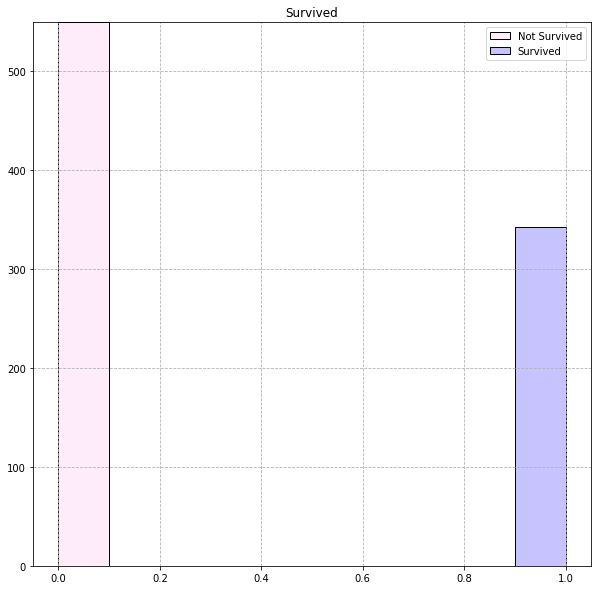

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Survived')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Survived'].dropna().values,data_train.query('Survived == 1').loc[:,'Survived'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

The dataset is a bit imbalanced so we need to take this into account when we asses the performance of the model.

([array([ 80.,   0.,   0.,   0.,   0.,  97.,   0.,   0.,   0., 372.]),
  array([216.,   0.,   0.,   0.,   0., 184.,   0.,   0.,   0., 491.])],
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 2 Lists of Patches objects>)

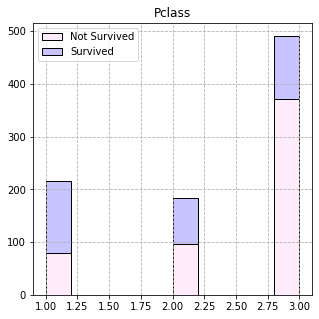

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Pclass')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Pclass'].dropna().values,data_train.query('Survived == 1').loc[:,'Pclass'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

We see that there is a tendency of Pclass=1 and Pclass=2 for 'Survived'. We will try to use this in the develpment of the models.

([array([468.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  81.]),
  array([577.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 314.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

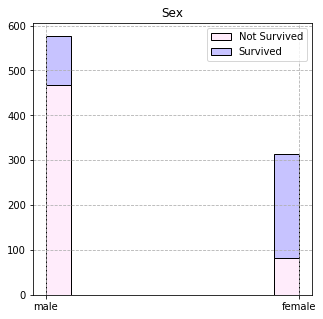

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Sex')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Sex'].dropna().values,data_train.query('Survived == 1').loc[:,'Sex'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

We see that there is a tendency of Sex=female for 'Survived'. We will try to use this in the develpment of the models.

([array([ 18.,  27., 114., 104.,  66.,  46.,  24.,  15.,   9.,   1.]),
  array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.])],
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 2 Lists of Patches objects>)

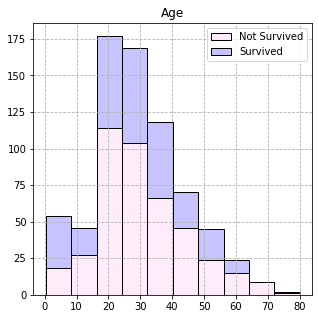

In [9]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Age')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Age'].dropna().values,data_train.query('Survived == 1').loc[:,'Age'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

We see that there is a tendency of Age<16 for 'Survived'. We will try to use this in the develpment of the models.

([array([398.,  97.,  15.,  12.,   0.,  15.,   5.,   0.,   0.,   7.]),
  array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.])],
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 2 Lists of Patches objects>)

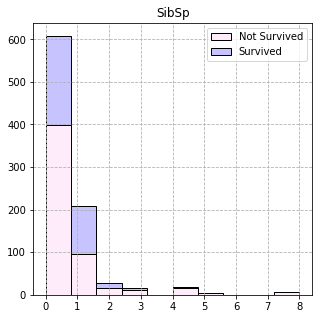

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('SibSp')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'SibSp'].dropna().values,data_train.query('Survived == 1').loc[:,'SibSp'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

([array([445.,  53.,   0.,  40.,   0.,   2.,   4.,   0.,   4.,   1.]),
  array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.])],
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 2 Lists of Patches objects>)

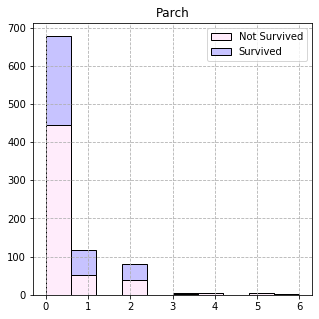

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Parch')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Parch'].dropna().values,data_train.query('Survived == 1').loc[:,'Parch'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

([array([499.,  36.,   8.,   0.,   4.,   2.,   0.,   0.,   0.,   0.]),
  array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.])],
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 2 Lists of Patches objects>)

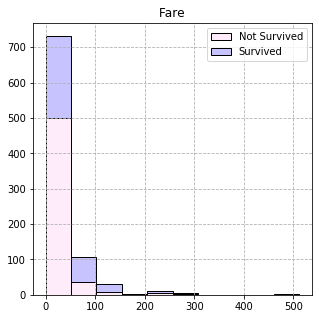

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Fare')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Fare'].dropna().values,data_train.query('Survived == 1').loc[:,'Fare'].dropna().values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

([array([427.,   0.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,  75.]),
  array([501.,   0.,   0.,   0.,   0.,  48.,   0.,   0.,   0., 123.])],
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 2 Lists of Patches objects>)

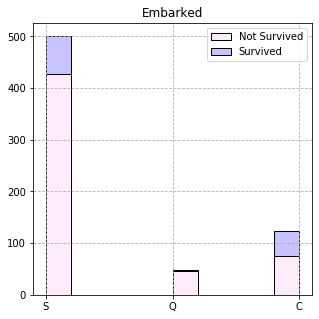

In [13]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Embarked')
hist = ax.hist([data_train.query('Survived == 0').loc[:,'Embarked'].dropna().values,data_train.query('Survived == 1').dropna().loc[:,'Embarked'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()
hist

With further exploration we obtain two examples that show that the dataset is problematic in the sense that two almost identical passengers are classfied completely different. This will heavely impact on the performanse of the models.

In [14]:
data_train.query('PassengerId == 401')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
400,401,1,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.925,NaN,S


In [15]:
data_train.query('PassengerId == 529')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
528,529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.925,NaN,S


-----

This function preprocess the dataset, creating and deleting features based on the past graphical analysis. This is done in preparation for the training and testing step.

In [16]:
def preprocess(data):    
    data.loc[:,'Pclass_1'] = data.loc[:,'Pclass']
    data.loc[:,['Pclass_1']] = data.loc[:,['Pclass_1']].applymap(lambda x:1. if (not pd.isna(x) and x==1) else 0.)
    data.loc[:,'Pclass_2'] = data.loc[:,'Pclass']
    data.loc[:,['Pclass_2']] = data.loc[:,['Pclass_2']].applymap(lambda x:1. if (not pd.isna(x) and x==2) else 0.)
    data.loc[:,'Pclass_3'] = data.loc[:,'Pclass']
    data.loc[:,['Pclass_3']] = data.loc[:,['Pclass_3']].applymap(lambda x:1. if (not pd.isna(x) and x==3) else 0.)
    data = data.drop('Pclass', axis=1, inplace=False)
    data = data.drop('Name', axis=1, inplace=False)
    data.loc[:,'Sex_male'] = data.loc[:,'Sex']
    data.loc[:,['Sex_male']] = data.loc[:,['Sex_male']].applymap(lambda x:1. if (not pd.isna(x) and x=='male') else 0.)
    data.loc[:,'Sex_female'] = data.loc[:,'Sex']
    data.loc[:,['Sex_female']] = data.loc[:,['Sex_female']].applymap(lambda x:1. if (not pd.isna(x) and x=='female') else 0.)
    data = data.drop('Sex', axis=1, inplace=False)
    data.loc[:,'Age_1'] = data.loc[:,'Age']
    data.loc[:,['Age_1']] = data.loc[:,['Age_1']].applymap(lambda x:1. if (not pd.isna(x) and x<=8) else 0.)
    data.loc[:,'Age_2'] = data.loc[:,'Age']
    data.loc[:,['Age_2']] = data.loc[:,['Age_2']].applymap(lambda x:1. if (not pd.isna(x) and 8<x<=15) else 0.)
    data.loc[:,'Age_3'] = data.loc[:,'Age']
    data.loc[:,['Age_3']] = data.loc[:,['Age_3']].applymap(lambda x:1. if (not pd.isna(x) and 15<x<=25) else 0.)
    data.loc[:,'Age_4'] = data.loc[:,'Age']
    data.loc[:,['Age_4']] = data.loc[:,['Age_4']].applymap(lambda x:1. if (not pd.isna(x) and 25<x<=35) else 0.)
    data.loc[:,'Age_5'] = data.loc[:,'Age']
    data.loc[:,['Age_5']] = data.loc[:,['Age_5']].applymap(lambda x:1. if (not pd.isna(x) and 35<x<=50) else 0.)
    data.loc[:,'Age_6'] = data.loc[:,'Age']
    data.loc[:,['Age_6']] = data.loc[:,['Age_6']].applymap(lambda x:1. if (not pd.isna(x) and 50<x<=65) else 0.)
    data.loc[:,'Age_7'] = data.loc[:,'Age']
    data.loc[:,['Age_7']] = data.loc[:,['Age_7']].applymap(lambda x:1. if (not pd.isna(x) and 65<x<=100) else 0.)
    data = data.drop('Age', axis=1, inplace=False)    
    data.loc[:,'Family_size'] = data.loc[:,'SibSp']+data.loc[:,'Parch']+1
    data = data.drop('SibSp', axis=1, inplace=False)
    data = data.drop('Parch', axis=1, inplace=False)
    data = data.drop('Ticket', axis=1, inplace=False)
    data.loc[:,'Fare_1'] = data.loc[:,'Fare']
    data.loc[:,['Fare_1']] = data.loc[:,['Fare_1']].applymap(lambda x:1. if (not pd.isna(x) and x<=15) else 0.)
    data.loc[:,'Fare_2'] = data.loc[:,'Fare']
    data.loc[:,['Fare_2']] = data.loc[:,['Fare_2']].applymap(lambda x:1. if (not pd.isna(x) and 15<x<=30) else 0.)
    data.loc[:,'Fare_3'] = data.loc[:,'Fare']
    data.loc[:,['Fare_3']] = data.loc[:,['Fare_3']].applymap(lambda x:1. if (not pd.isna(x) and 30<x<=45) else 0.)
    data.loc[:,'Fare_4'] = data.loc[:,'Fare']
    data.loc[:,['Fare_4']] = data.loc[:,['Fare_4']].applymap(lambda x:1. if (not pd.isna(x) and 45<x<=60) else 0.)
    data.loc[:,'Fare_5'] = data.loc[:,'Fare']
    data.loc[:,['Fare_5']] = data.loc[:,['Fare_5']].applymap(lambda x:1. if (not pd.isna(x) and 60<x<=600) else 0.)
    data = data.drop('Fare', axis=1, inplace=False)
    data.loc[:,'Cabin_num'] = data.loc[:,'Cabin']
    data.loc[:,['Cabin_num']] = data.loc[:,['Cabin_num']].applymap(lambda x:len(re.split(' ',x)) if not pd.isna(x) else 0.)
    data = data.drop('Cabin', axis=1, inplace=False)
    data.loc[:,'Embarked_C'] = data.loc[:,'Embarked']
    data.loc[:,['Embarked_C']] = data.loc[:,['Embarked_C']].applymap(lambda x:1. if (not pd.isna(x) and x=='C') else 0.)
    data.loc[:,'Embarked_Q'] = data.loc[:,'Embarked']
    data.loc[:,['Embarked_Q']] = data.loc[:,['Embarked_Q']].applymap(lambda x:1. if (not pd.isna(x) and x=='Q') else 0.)
    data.loc[:,'Embarked_S'] = data.loc[:,'Embarked']
    data.loc[:,['Embarked_S']] = data.loc[:,['Embarked_S']].applymap(lambda x:1. if (not pd.isna(x) and x=='S') else 0.)
    data = data.drop('Embarked', axis=1, inplace=False)
    return data

In [17]:
data_train = preprocess(data_train)
data_train.head()

,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_male,Sex_female,Age_1,Age_2,Age_3,...,Family_size,Fare_1,Fare_2,Fare_3,Fare_4,Fare_5,Cabin_num,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,3,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
data_test = preprocess(data_test)
data_test.head()

,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_male,Sex_female,Age_1,Age_2,Age_3,...,Family_size,Fare_1,Fare_2,Fare_3,Fare_4,Fare_5,Cabin_num,Embarked_C,Embarked_Q,Embarked_S
0,892,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


-----

Here we make different plots of the preprocessed dataset in an attempt to extract some additional information for the development of the models.

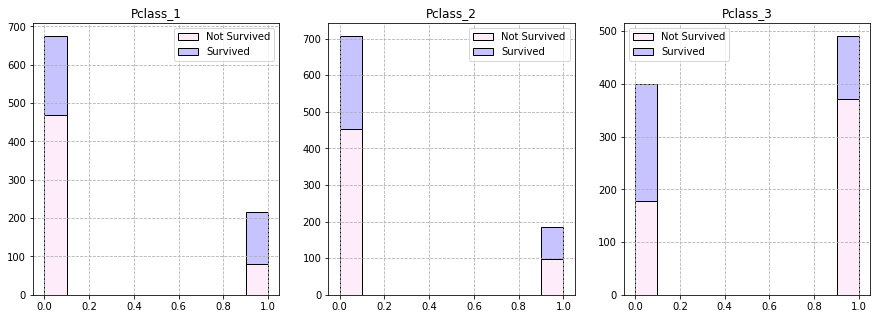

In [19]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.grid(b=True, linestyle='--')
ax1.set_title('Pclass_1')
ax1.hist([data_train.query('Survived == 0').loc[:,'Pclass_1'].values,data_train.query('Survived == 1').loc[:,'Pclass_1'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax1.legend()
ax2 = fig.add_subplot(1, 3, 2)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Pclass_2')
ax2.hist([data_train.query('Survived == 0').loc[:,'Pclass_2'].values,data_train.query('Survived == 1').loc[:,'Pclass_2'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()
ax3 = fig.add_subplot(1, 3, 3)
ax3.grid(b=True, linestyle='--')
ax3.set_title('Pclass_3')
ax3.hist([data_train.query('Survived == 0').loc[:,'Pclass_3'].values,data_train.query('Survived == 1').loc[:,'Pclass_3'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax3.legend()

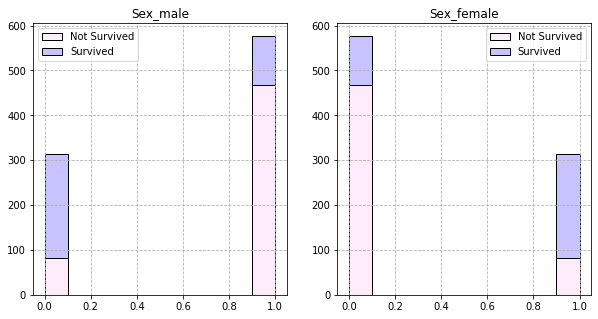

In [20]:
fig = plt.figure(figsize=(10, 5))
ax2 = fig.add_subplot(1, 2, 1)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Sex_male')
ax2.hist([data_train.query('Survived == 0').loc[:,'Sex_male'].values,data_train.query('Survived == 1').loc[:,'Sex_male'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()
ax2 = fig.add_subplot(1, 2, 2)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Sex_female')
ax2.hist([data_train.query('Survived == 0').loc[:,'Sex_female'].values,data_train.query('Survived == 1').loc[:,'Sex_female'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()

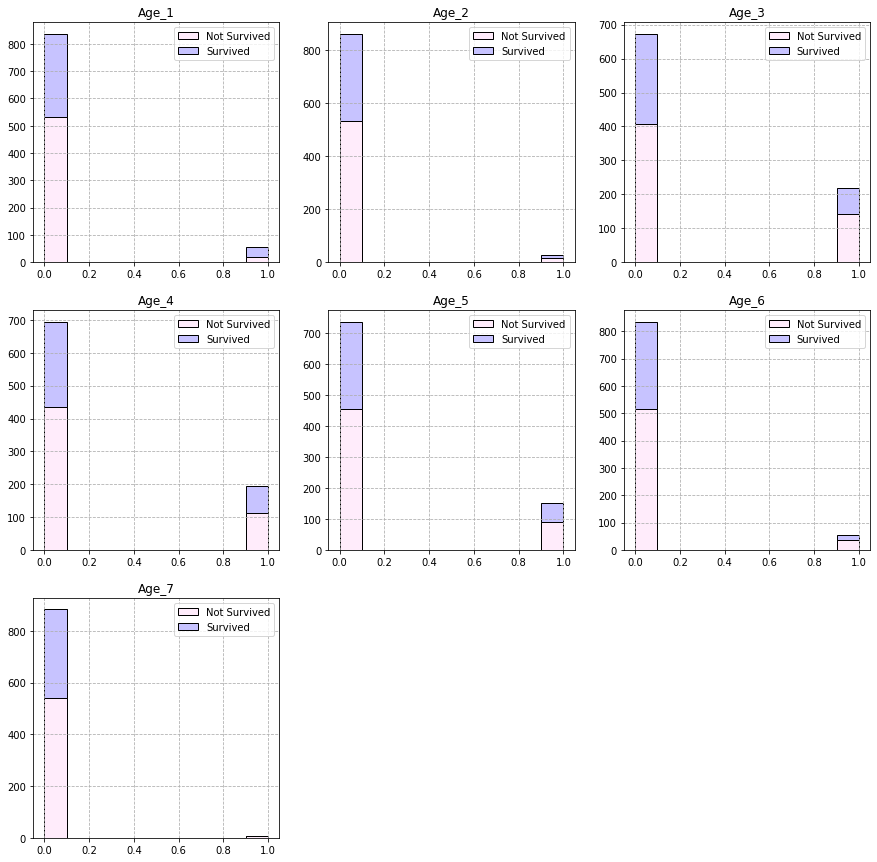

In [21]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(3, 3, 1)
ax1.grid(b=True, linestyle='--')
ax1.set_title('Age_1')
ax1.hist([data_train.query('Survived == 0').loc[:,'Age_1'].values,data_train.query('Survived == 1').loc[:,'Age_1'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax1.legend()
ax2 = fig.add_subplot(3, 3, 2)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Age_2')
ax2.hist([data_train.query('Survived == 0').loc[:,'Age_2'].values,data_train.query('Survived == 1').loc[:,'Age_2'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()
ax3 = fig.add_subplot(3, 3, 3)
ax3.grid(b=True, linestyle='--')
ax3.set_title('Age_3')
ax3.hist([data_train.query('Survived == 0').loc[:,'Age_3'].values,data_train.query('Survived == 1').loc[:,'Age_3'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax3.legend()
ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(b=True, linestyle='--')
ax4.set_title('Age_4')
ax4.hist([data_train.query('Survived == 0').loc[:,'Age_4'].values,data_train.query('Survived == 1').loc[:,'Age_4'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax4.legend()
ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(b=True, linestyle='--')
ax5.set_title('Age_5')
ax5.hist([data_train.query('Survived == 0').loc[:,'Age_5'].values,data_train.query('Survived == 1').loc[:,'Age_5'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax5.legend()
ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(b=True, linestyle='--')
ax6.set_title('Age_6')
ax6.hist([data_train.query('Survived == 0').loc[:,'Age_6'].values,data_train.query('Survived == 1').loc[:,'Age_6'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax6.legend()
ax7 = fig.add_subplot(3, 3, 7)
ax7.grid(b=True, linestyle='--')
ax7.set_title('Age_7')
ax7.hist([data_train.query('Survived == 0').loc[:,'Age_7'].values,data_train.query('Survived == 1').loc[:,'Age_7'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax7.legend()

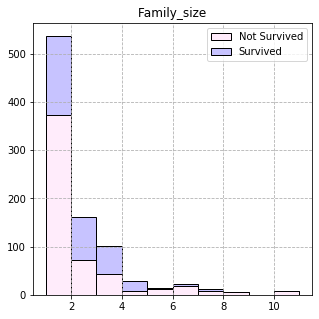

In [22]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Family_size')
ax.hist([data_train.query('Survived == 0').loc[:,'Family_size'].values,data_train.query('Survived == 1').loc[:,'Family_size'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()

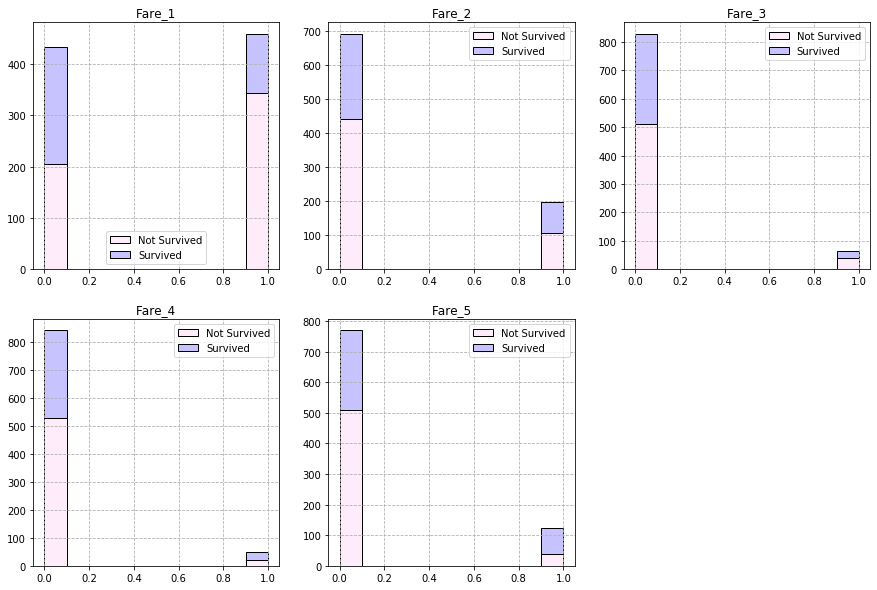

In [23]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 3, 1)
ax1.grid(b=True, linestyle='--')
ax1.set_title('Fare_1')
ax1.hist([data_train.query('Survived == 0').loc[:,'Fare_1'].values,data_train.query('Survived == 1').loc[:,'Fare_1'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax1.legend()
ax2 = fig.add_subplot(2, 3, 2)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Fare_2')
ax2.hist([data_train.query('Survived == 0').loc[:,'Fare_2'].values,data_train.query('Survived == 1').loc[:,'Fare_2'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()
ax3 = fig.add_subplot(2, 3, 3)
ax3.grid(b=True, linestyle='--')
ax3.set_title('Fare_3')
ax3.hist([data_train.query('Survived == 0').loc[:,'Fare_3'].values,data_train.query('Survived == 1').loc[:,'Fare_3'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax3.legend()
ax4 = fig.add_subplot(2, 3, 4)
ax4.grid(b=True, linestyle='--')
ax4.set_title('Fare_4')
ax4.hist([data_train.query('Survived == 0').loc[:,'Fare_4'].values,data_train.query('Survived == 1').loc[:,'Fare_4'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax4.legend()
ax5 = fig.add_subplot(2, 3, 5)
ax5.grid(b=True, linestyle='--')
ax5.set_title('Fare_5')
ax5.hist([data_train.query('Survived == 0').loc[:,'Fare_5'].values,data_train.query('Survived == 1').loc[:,'Fare_5'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax5.legend()

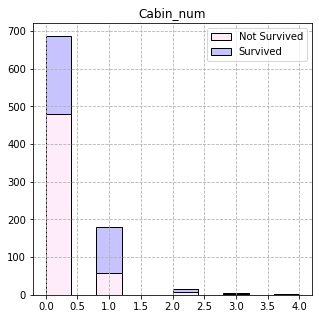

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_title('Cabin_num')
ax.hist([data_train.query('Survived == 0').loc[:,'Cabin_num'].values,data_train.query('Survived == 1').loc[:,'Cabin_num'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax.legend()

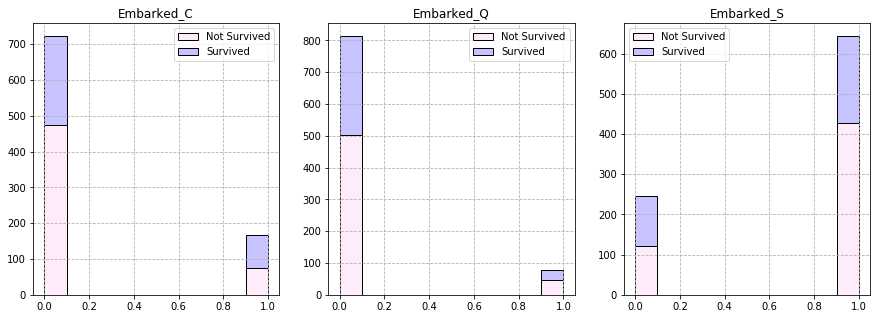

In [25]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.grid(b=True, linestyle='--')
ax1.set_title('Embarked_C')
ax1.hist([data_train.query('Survived == 0').loc[:,'Embarked_C'].values,data_train.query('Survived == 1').loc[:,'Embarked_C'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax1.legend()
ax2 = fig.add_subplot(1, 3, 2)
ax2.grid(b=True, linestyle='--')
ax2.set_title('Embarked_Q')
ax2.hist([data_train.query('Survived == 0').loc[:,'Embarked_Q'].values,data_train.query('Survived == 1').loc[:,'Embarked_Q'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax2.legend()
ax3 = fig.add_subplot(1, 3, 3)
ax3.grid(b=True, linestyle='--')
ax3.set_title('Embarked_S')
ax3.hist([data_train.query('Survived == 0').loc[:,'Embarked_S'].values,data_train.query('Survived == 1').loc[:,'Embarked_S'].values], color=['#FFECFB', '#C7C3FF'], edgecolor='#000000', label=['Not Survived', 'Survived'], stacked=True)
ax3.legend()

-----

This function plots the confusion matrix of the model predictions and it will be used to analize its performance

In [26]:
def plot_confusion_matrix(model, X, Y):    
    y_pred = model.predict(X).flatten()
    y_true = Y.flatten()
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[1.,0.])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_xticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.set_yticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.text(0., 0., str(cm[0,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 0., str(cm[0,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(0., 1., str(cm[1,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 1., str(cm[1,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    im = ax.imshow(cm)
    fig.colorbar(mappable=im, ax=ax, shrink=0.8)
    print(classification_report(y_true, y_pred, digits=4, output_dict=False)) 

-----

Here we define the datasets for training and testing.

In [27]:
X_train = (data_train.iloc[:,2:].values).astype(float)
Y_train = (data_train.iloc[:,[1]].values).astype(float)

X_test = (data_test.iloc[:,2:].values).astype(float)
Y_test = (data_test.iloc[:,[1]].values).astype(float)

In [28]:
b = np.max(X_train, axis=0)+0.000001
a = np.min(X_train, axis=0)-0.000001

-----

Here we train our first model and evaluate its performance. It is a KNN classifier with n=1 just to have a baseline model.

In [29]:
knn = Pipeline([('lambda', FunctionTransformer(lambda x:(x-a)/(b-a))),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

knn.fit(X_train, Y_train.flatten())

Pipeline(memory=None,
         steps=[('lambda',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function <lambda> at 0x7fb1505bd510>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbose=False)

In [30]:
class Model_1():
    
    def predict(self, X):
        A1 = knn.predict(X)
        A2 = np.expand_dims(A1, axis=-1)   
        return A2 
    
    def predict_logit(self, X):
        A1 = self.predict(X)
        A2 = A1*0.9999999999999999 + (1-A1)*0.0000000000000001
        A3 = np.log(A2/(1-A2))
        return A3

In [31]:
model_1 = Model_1()

              precision    recall  f1-score   support

         0.0     0.9035    0.8525    0.8772       549
         1.0     0.7828    0.8538    0.8168       342

    accuracy                         0.8530       891
   macro avg     0.8432    0.8531    0.8470       891
weighted avg     0.8572    0.8530    0.8540       891



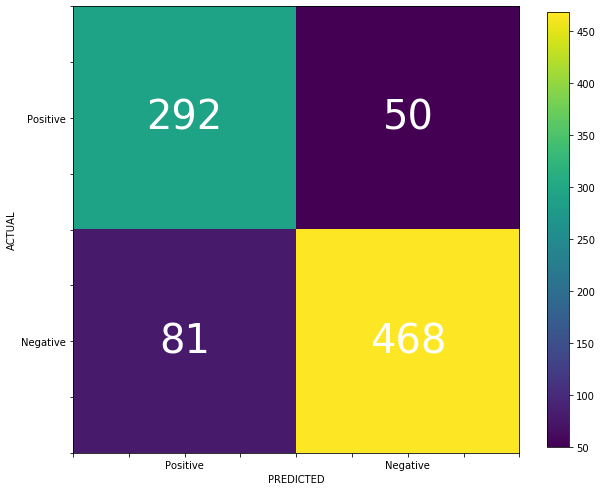

In [32]:
plot_confusion_matrix(model_1, X_train, Y_train)

In [33]:
np.mean(1-np.square(np.sign(Y_test-model_1.predict(X_test))))

0.7129186602870813

We see that this model is overfitting and performing worse than the baseline model on the test set, so we discard it.

-----

Here we define our second model and evaluate its performance. It is a "women survive" based classifier.

In [34]:
class Model_2():
            
    def predict(self, X):
        A1 = X[:,4] 
        A2 = np.expand_dims(A1, axis=-1)   
        return A2  
    
    def predict_logit(self, X):
        A1 = self.predict(X)
        A2 = A1*0.9999999999999999 + (1-A1)*0.0000000000000001
        A3 = np.log(A2/(1-A2))
        return A3

In [35]:
model_2 = Model_2()

              precision    recall  f1-score   support

         0.0     0.8111    0.8525    0.8313       549
         1.0     0.7420    0.6813    0.7104       342

    accuracy                         0.7868       891
   macro avg     0.7766    0.7669    0.7708       891
weighted avg     0.7846    0.7868    0.7849       891



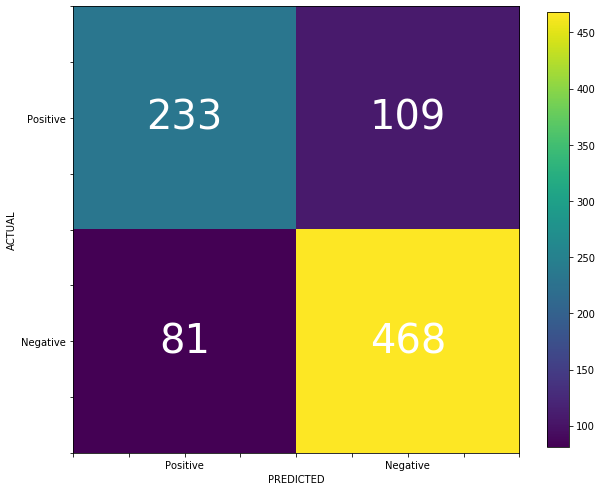

In [36]:
plot_confusion_matrix(model_2, X_train, Y_train)

In [37]:
np.mean(1-np.square(np.sign(Y_test-model_2.predict(X_test))))

0.7655502392344498

We see that this model is performing better than the baseline model on the test set, so we take it as the new baseline model to beat.

-----

Here we define our third model and evaluate its performance. It is a "women and children survive" based classifier.

In [38]:
class Model_3():
        
    def predict(self, X):
        A1 = X[:,4]+X[:,3]*X[:,5]     
        A2 = np.expand_dims(A1, axis=-1)   
        return A2  
    
    def predict_logit(self, X):
        A1 = self.predict(X)
        A2 = A1*0.9999999999999999 + (1-A1)*0.0000000000000001
        A3 = np.log(A2/(1-A2))
        return A3

In [39]:
model_3 = Model_3()

              precision    recall  f1-score   support

         0.0     0.8324    0.8324    0.8324       549
         1.0     0.7310    0.7310    0.7310       342

    accuracy                         0.7935       891
   macro avg     0.7817    0.7817    0.7817       891
weighted avg     0.7935    0.7935    0.7935       891



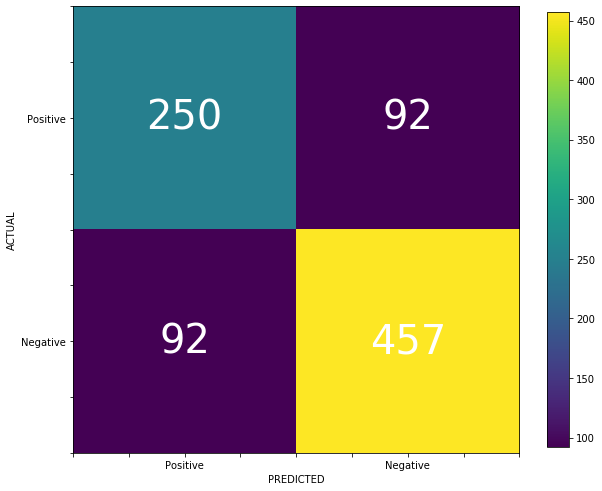

In [40]:
plot_confusion_matrix(model_3, X_train, Y_train)

In [41]:
np.mean(1-np.square(np.sign(Y_test-model_3.predict(X_test))))

0.7655502392344498

We see that this model is performing a bit better than the last one, so we take it as the new baseline model to beat.

-----

Here we define our fourth model and evaluate its performance. It is a "women and children of class 1 or 2 survive" based classifier.

In [42]:
class Model_4():
    
    def predict(self, X):
        A1 = (X[:,0]+X[:,1])*(X[:,4] + X[:,3]*X[:,5]+X[:,3]*X[:,6])  
        A2 = np.expand_dims(A1, axis=-1)
        return A2
    
    def predict_logit(self, X):
        A1 = self.predict(X)
        A2 = A1*0.9999999999999999 + (1-A1)*0.0000000000000001
        A3 = np.log(A2/(1-A2))
        return A3

In [43]:
model_4 = Model_4()

              precision    recall  f1-score   support

         0.0     0.7616    0.9836    0.8585       549
         1.0     0.9505    0.5058    0.6603       342

    accuracy                         0.8002       891
   macro avg     0.8561    0.7447    0.7594       891
weighted avg     0.8341    0.8002    0.7824       891



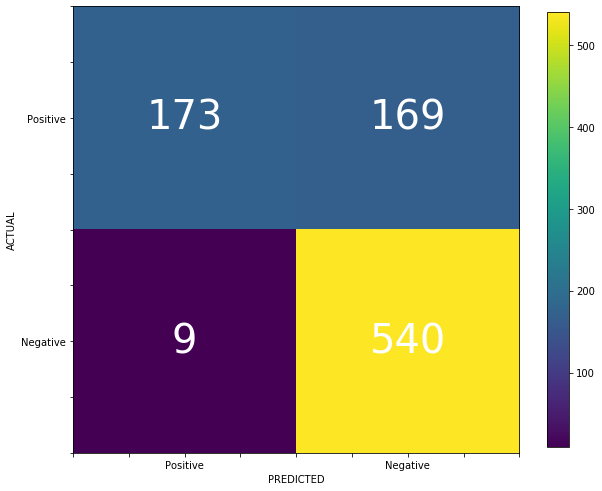

In [44]:
plot_confusion_matrix(model_4, X_train, Y_train)

In [45]:
np.mean(1-np.square(np.sign(Y_test-model_4.predict(X_test))))

0.7822966507177034

We see that this model is performing a better than the last one, so we take it as the new baseline model to beat.

-----

Here we define our fifth model and evaluate its performance. This new model will boost the last model and to do so, we use a special trick and transform the original classification problem to a regression problem. Then we use the error of the last model as the output to predict. The new model will be an ensemble of the last one and the one we trained.

In [46]:
Y_train_ = Y_train*0.9999999999999999 + (1-Y_train)*0.0000000000000001
Y_train_ = np.log(Y_train_/(1-Y_train_))

In [47]:
R1_train = Y_train_ - model_4.predict_logit(X_train)

In [48]:
adaboost = Pipeline([('lambda', FunctionTransformer(lambda x:(x-a)/(b-a))),
                     ('adaboost', AdaBoostRegressor())]) 

adaboost.fit(X_train, R1_train.flatten())

Pipeline(memory=None,
         steps=[('lambda',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function <lambda> at 0x7fb151c49ae8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('adaboost',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=None))],
         verbose=False)

In [49]:
class Model_5():
    
    def predict(self, X):
        A1 = self.predict_logit(X)       
        A2 = 1/(1+np.exp(-A1))
        A3 = np.sign(1+np.sign(A2-0.5))   
        return A3
    
    def predict_logit(self, X):
        A1 = model_4.predict_logit(X) + np.expand_dims(adaboost.predict(X), axis=-1)
        return A1

In [50]:
model_5 = Model_5()

              precision    recall  f1-score   support

         0.0     0.7738    0.9781    0.8640       549
         1.0     0.9391    0.5409    0.6865       342

    accuracy                         0.8103       891
   macro avg     0.8564    0.7595    0.7752       891
weighted avg     0.8372    0.8103    0.7959       891



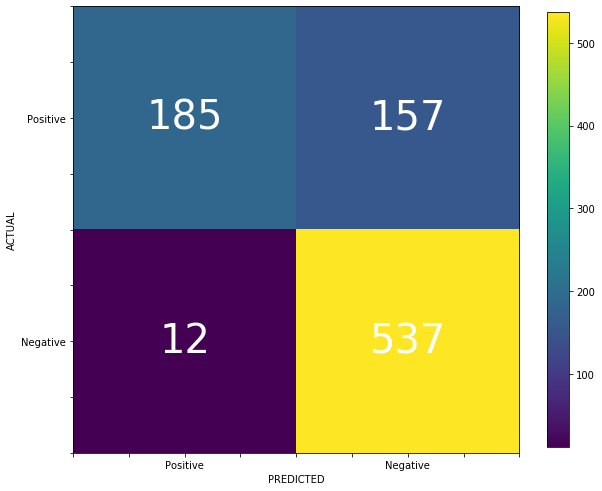

In [51]:
plot_confusion_matrix(model_5, X_train, Y_train)

In [52]:
np.mean(1-np.square(np.sign(Y_test-model_5.predict(X_test))))

0.7918660287081339


As expected, we see that this model is an improvement of the last one, so we take it as the new baseline model to beat.

-----

Here we define our sixth model and evaluate its performance. This new model will apply the same idea as before and boost the last model using the same special trick. The new model will be an ensemble of the last one and the one we trained.

In [53]:
R2_train = Y_train_ - model_5.predict_logit(X_train)

In [54]:
def NN():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(function=lambda x: (x-a)/(b-a),
                                     input_shape=[X_train.shape[1]]))
    model.add(tf.keras.layers.Dense(units=64, 
                                    activation='relu', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(units=64, 
                                    activation='relu', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(R2_train.shape[1], 
                                    activation='linear', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    model.compile(loss='mse', metrics=['mae'], optimizer=optimizer)
    model.summary()
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     patience=100,
                                                     min_delta=0.001,
                                                     factor=0.1, 
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=200,
                                                 min_delta=0.001)
    model.fit(X_train, R2_train, epochs=10000, batch_size=16, callbacks=[callback1, callback2], verbose=True)
    return model

In [55]:
nn = NN() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 22)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
______________________________________________________

891/891 [==============================] - 0s 72us/sample - loss: 597.9575 - mae: 17.1221
Epoch 68/10000
891/891 [==============================] - 0s 75us/sample - loss: 612.6522 - mae: 17.6653
Epoch 69/10000
891/891 [==============================] - 0s 71us/sample - loss: 601.6389 - mae: 17.6471
Epoch 70/10000
891/891 [==============================] - 0s 83us/sample - loss: 593.1426 - mae: 17.4092
Epoch 71/10000
891/891 [==============================] - 0s 76us/sample - loss: 610.7454 - mae: 17.5073
Epoch 72/10000
891/891 [==============================] - 0s 78us/sample - loss: 620.5903 - mae: 17.7539
Epoch 73/10000
891/891 [==============================] - 0s 80us/sample - loss: 600.0990 - mae: 17.5994
Epoch 74/10000
891/891 [==============================] - 0s 76us/sample - loss: 597.5094 - mae: 17.2917
Epoch 75/10000
891/891 [==============================] - 0s 70us/sample - loss: 590.4069 - mae: 17.0784
Epoch 76/10000
891/891 [==============================] - 0s 70us/samp

891/891 [==============================] - 0s 73us/sample - loss: 554.6283 - mae: 16.5497
Epoch 145/10000
891/891 [==============================] - 0s 69us/sample - loss: 553.1409 - mae: 16.0319
Epoch 146/10000
891/891 [==============================] - 0s 68us/sample - loss: 560.3681 - mae: 16.3632
Epoch 147/10000
891/891 [==============================] - 0s 66us/sample - loss: 557.0928 - mae: 16.1310
Epoch 148/10000
891/891 [==============================] - 0s 64us/sample - loss: 588.0021 - mae: 16.5787
Epoch 149/10000
891/891 [==============================] - 0s 71us/sample - loss: 550.7755 - mae: 16.1843
Epoch 150/10000
891/891 [==============================] - 0s 69us/sample - loss: 563.6091 - mae: 16.6106
Epoch 151/10000
891/891 [==============================] - 0s 65us/sample - loss: 550.3829 - mae: 16.2375
Epoch 152/10000
891/891 [==============================] - 0s 74us/sample - loss: 555.0258 - mae: 16.2671
Epoch 153/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 73us/sample - loss: 566.1014 - mae: 16.2489
Epoch 222/10000
891/891 [==============================] - 0s 72us/sample - loss: 552.0846 - mae: 16.0951
Epoch 223/10000
891/891 [==============================] - 0s 68us/sample - loss: 555.0651 - mae: 16.3082
Epoch 224/10000
891/891 [==============================] - 0s 66us/sample - loss: 547.2730 - mae: 16.0578
Epoch 225/10000
891/891 [==============================] - 0s 70us/sample - loss: 547.3452 - mae: 16.1720
Epoch 226/10000
891/891 [==============================] - 0s 70us/sample - loss: 543.8841 - mae: 15.7080
Epoch 227/10000
891/891 [==============================] - 0s 65us/sample - loss: 531.2971 - mae: 15.9027
Epoch 228/10000
891/891 [==============================] - 0s 70us/sample - loss: 540.9494 - mae: 16.0311
Epoch 229/10000
891/891 [==============================] - 0s 63us/sample - loss: 538.8911 - mae: 16.1105
Epoch 230/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 69us/sample - loss: 541.4967 - mae: 15.9113
Epoch 299/10000
891/891 [==============================] - 0s 77us/sample - loss: 551.9522 - mae: 16.1698
Epoch 300/10000
891/891 [==============================] - 0s 68us/sample - loss: 542.3646 - mae: 16.0925
Epoch 301/10000
891/891 [==============================] - 0s 70us/sample - loss: 549.5387 - mae: 16.0962
Epoch 302/10000
891/891 [==============================] - 0s 65us/sample - loss: 534.7115 - mae: 16.1249
Epoch 303/10000
891/891 [==============================] - 0s 70us/sample - loss: 553.9946 - mae: 16.4024
Epoch 304/10000
891/891 [==============================] - 0s 71us/sample - loss: 533.1541 - mae: 15.9358
Epoch 305/10000
891/891 [==============================] - 0s 75us/sample - loss: 518.6976 - mae: 15.5880
Epoch 306/10000
891/891 [==============================] - 0s 68us/sample - loss: 539.5096 - mae: 15.9443
Epoch 307/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 67us/sample - loss: 551.2261 - mae: 16.2575
Epoch 376/10000
891/891 [==============================] - 0s 69us/sample - loss: 538.4766 - mae: 15.7191
Epoch 377/10000
891/891 [==============================] - 0s 65us/sample - loss: 518.9351 - mae: 15.6764
Epoch 378/10000
891/891 [==============================] - 0s 70us/sample - loss: 534.6841 - mae: 15.4982
Epoch 379/10000
891/891 [==============================] - 0s 66us/sample - loss: 546.1792 - mae: 16.0008
Epoch 380/10000
891/891 [==============================] - 0s 66us/sample - loss: 544.8496 - mae: 16.0296
Epoch 381/10000
891/891 [==============================] - 0s 69us/sample - loss: 539.5133 - mae: 15.9891
Epoch 382/10000
891/891 [==============================] - 0s 68us/sample - loss: 540.1987 - mae: 15.7874
Epoch 383/10000
891/891 [==============================] - 0s 62us/sample - loss: 523.0567 - mae: 15.2874
Epoch 384/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 63us/sample - loss: 499.6899 - mae: 14.7380
Epoch 453/10000
891/891 [==============================] - 0s 70us/sample - loss: 515.1955 - mae: 15.0422
Epoch 454/10000
891/891 [==============================] - 0s 66us/sample - loss: 513.4871 - mae: 15.0299
Epoch 455/10000
891/891 [==============================] - 0s 66us/sample - loss: 510.2528 - mae: 14.9391
Epoch 456/10000
891/891 [==============================] - 0s 63us/sample - loss: 503.6746 - mae: 14.9456
Epoch 457/10000
891/891 [==============================] - 0s 64us/sample - loss: 523.1444 - mae: 15.0336
Epoch 458/10000
891/891 [==============================] - 0s 66us/sample - loss: 506.3950 - mae: 15.0300
Epoch 459/10000
891/891 [==============================] - 0s 64us/sample - loss: 517.5440 - mae: 15.2224
Epoch 460/10000
891/891 [==============================] - 0s 69us/sample - loss: 493.7535 - mae: 14.8519
Epoch 461/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 69us/sample - loss: 501.5328 - mae: 15.0417
Epoch 530/10000
891/891 [==============================] - 0s 66us/sample - loss: 521.0742 - mae: 15.1195
Epoch 531/10000
891/891 [==============================] - 0s 69us/sample - loss: 523.1980 - mae: 15.2691
Epoch 532/10000
891/891 [==============================] - 0s 70us/sample - loss: 501.3766 - mae: 14.7631
Epoch 533/10000
891/891 [==============================] - 0s 67us/sample - loss: 500.1274 - mae: 14.7497
Epoch 534/10000
891/891 [==============================] - 0s 67us/sample - loss: 525.2491 - mae: 15.1620
Epoch 535/10000
891/891 [==============================] - 0s 64us/sample - loss: 511.0434 - mae: 14.9551
Epoch 536/10000
891/891 [==============================] - 0s 68us/sample - loss: 507.5699 - mae: 14.9788
Epoch 537/10000
891/891 [==============================] - 0s 69us/sample - loss: 500.0417 - mae: 14.8413
Epoch 538/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 71us/sample - loss: 512.5871 - mae: 14.7844
Epoch 607/10000
891/891 [==============================] - 0s 74us/sample - loss: 520.8577 - mae: 15.0119
Epoch 608/10000
891/891 [==============================] - 0s 70us/sample - loss: 491.3652 - mae: 14.6889
Epoch 609/10000
891/891 [==============================] - 0s 67us/sample - loss: 506.5575 - mae: 14.8409
Epoch 610/10000
891/891 [==============================] - 0s 69us/sample - loss: 500.7096 - mae: 14.9765
Epoch 611/10000
891/891 [==============================] - 0s 77us/sample - loss: 499.1214 - mae: 14.6700
Epoch 612/10000
891/891 [==============================] - 0s 74us/sample - loss: 506.6151 - mae: 15.0339
Epoch 613/10000
891/891 [==============================] - 0s 71us/sample - loss: 499.0170 - mae: 14.5815
Epoch 614/10000
891/891 [==============================] - 0s 71us/sample - loss: 504.3634 - mae: 14.8282
Epoch 615/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 204us/sample - loss: 490.3666 - mae: 14.5700
Epoch 684/10000
891/891 [==============================] - 0s 157us/sample - loss: 496.7785 - mae: 14.7374
Epoch 685/10000
891/891 [==============================] - 0s 90us/sample - loss: 513.2543 - mae: 14.9147
Epoch 686/10000
891/891 [==============================] - 0s 86us/sample - loss: 508.6328 - mae: 14.9957
Epoch 687/10000
891/891 [==============================] - 0s 93us/sample - loss: 501.7466 - mae: 14.8084
Epoch 688/10000
891/891 [==============================] - 0s 86us/sample - loss: 498.3206 - mae: 14.6808
Epoch 689/10000
891/891 [==============================] - 0s 77us/sample - loss: 494.9425 - mae: 14.6510
Epoch 690/10000
891/891 [==============================] - 0s 113us/sample - loss: 494.8141 - mae: 14.8163
Epoch 691/10000
891/891 [==============================] - 0s 79us/sample - loss: 473.7538 - mae: 14.5072
Epoch 692/10000
891/891 [==============================] - 

891/891 [==============================] - 0s 64us/sample - loss: 466.5068 - mae: 14.2698
Epoch 761/10000
891/891 [==============================] - 0s 68us/sample - loss: 496.4024 - mae: 14.7555
Epoch 762/10000
891/891 [==============================] - 0s 70us/sample - loss: 514.8370 - mae: 14.8157
Epoch 763/10000
891/891 [==============================] - 0s 70us/sample - loss: 505.1716 - mae: 14.9554
Epoch 764/10000
891/891 [==============================] - 0s 66us/sample - loss: 497.2514 - mae: 14.6617
Epoch 765/10000
891/891 [==============================] - 0s 65us/sample - loss: 501.9031 - mae: 14.8720
Epoch 766/10000
891/891 [==============================] - 0s 67us/sample - loss: 497.4924 - mae: 14.7648
Epoch 767/10000
891/891 [==============================] - 0s 77us/sample - loss: 514.8305 - mae: 14.7903
Epoch 768/10000
891/891 [==============================] - 0s 95us/sample - loss: 488.6230 - mae: 14.5577
Epoch 769/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 60us/sample - loss: 473.8243 - mae: 14.2562
Epoch 838/10000
891/891 [==============================] - 0s 61us/sample - loss: 507.3336 - mae: 14.9847
Epoch 839/10000
891/891 [==============================] - 0s 59us/sample - loss: 477.9275 - mae: 14.5215
Epoch 840/10000
891/891 [==============================] - 0s 66us/sample - loss: 505.2404 - mae: 14.8038
Epoch 841/10000
891/891 [==============================] - 0s 59us/sample - loss: 497.6496 - mae: 14.7685
Epoch 842/10000
891/891 [==============================] - 0s 58us/sample - loss: 502.0354 - mae: 14.7821
Epoch 843/10000
891/891 [==============================] - 0s 58us/sample - loss: 502.5720 - mae: 14.9335
Epoch 844/10000
891/891 [==============================] - 0s 58us/sample - loss: 507.8734 - mae: 14.9803
Epoch 845/10000
891/891 [==============================] - 0s 58us/sample - loss: 500.0350 - mae: 14.7506
Epoch 846/10000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 59us/sample - loss: 509.0799 - mae: 15.0202
Epoch 915/10000
891/891 [==============================] - 0s 59us/sample - loss: 501.2765 - mae: 14.6252
Epoch 916/10000
891/891 [==============================] - 0s 59us/sample - loss: 499.2708 - mae: 14.8403
Epoch 917/10000
891/891 [==============================] - 0s 58us/sample - loss: 481.2701 - mae: 14.6563
Epoch 918/10000
891/891 [==============================] - 0s 58us/sample - loss: 488.9745 - mae: 14.5680
Epoch 919/10000
891/891 [==============================] - 0s 62us/sample - loss: 512.6864 - mae: 14.8463
Epoch 920/10000
891/891 [==============================] - 0s 61us/sample - loss: 490.9229 - mae: 14.5832
Epoch 921/10000
891/891 [==============================] - 0s 59us/sample - loss: 496.0788 - mae: 14.7376
Epoch 922/10000
891/891 [==============================] - 0s 58us/sample - loss: 483.9353 - mae: 14.3202
Epoch 923/10000
891/891 [==============================] - 0s 

In [56]:
class Model_6():
    
    def predict(self, X):
        A1 = self.predict_logit(X)       
        A2 = 1/(1+np.exp(-A1))
        A3 = np.sign(1+np.sign(A2-0.5))   
        return A3
    
    def predict_logit(self, X):
        A1 = model_5.predict_logit(X) + nn.predict(X)
        return A1

In [57]:
model_6 = Model_6()

              precision    recall  f1-score   support

         0.0     0.8904    0.9326    0.9110       549
         1.0     0.8829    0.8158    0.8480       342

    accuracy                         0.8878       891
   macro avg     0.8867    0.8742    0.8795       891
weighted avg     0.8875    0.8878    0.8868       891



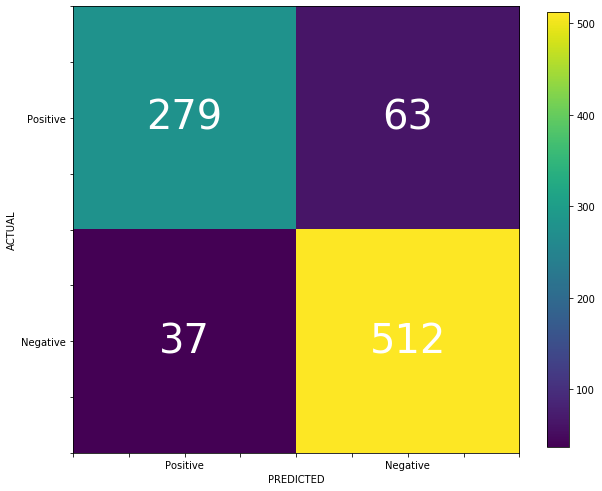

In [58]:
plot_confusion_matrix(model_6, X_train, Y_train)

In [59]:
np.mean(1-np.square(np.sign(Y_test-model_6.predict(X_test))))

0.80622009569378


As expected, we see that this model is perfoming better than the last one.

#### This last model could be considered a candidate solution for the original problem presented. Additional exploration of machine learning and deep learning models would be necessary to make a final conclusion.

-----

In [60]:
output = pd.DataFrame({'PassengerId': data_test.loc[:,'PassengerId'], 'Survived': (model_6.predict(X_test).flatten()).astype(int)})
output.to_csv('my_submission.csv', index=False)